In [0]:
df1 = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/ds_salaries.csv")

In [0]:
# Display the first few rows of the dataset
df1.show()

+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|work_year|experience_level|employment_type|           job_title|salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|
+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|     2023|              SE|             FT|Principal Data Sc...| 80000|            EUR|        85847|                ES|         100|              ES|           L|
|     2023|              MI|             CT|         ML Engineer| 30000|            USD|        30000|                US|         100|              US|           S|
|     2023|              MI|             CT|         ML Engineer| 25500|            USD|        25500|                US|         100|              US|           S|
|     2023

In [0]:
from pyspark.sql.functions import col
from pyspark.sql.functions import count, when, isnan

# Data types
data_info = df1.dtypes

# Unique values for each column
unique_values = {column: df1.select(column).distinct().count() for column in df1.columns}

# Count missing values for each column
missing_values = df1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df1.columns])

# Statistical summary
statistical_summary = df1.describe()

In [0]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `df1` is your Spark DataFrame
numerical_columns = [field.name for field in df1.schema.fields if field.dataType.simpleString() == 'int']

# Collecting data to the driver for plotting
pandas_df = df1.select(*numerical_columns).toPandas()

plt.figure(figsize=(15, 5))

for i, col in enumerate(numerical_columns):
    plt.subplot(1, len(numerical_columns), i+1)
    sns.boxplot(y=pandas_df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

<Figure size 1080x360 with 0 Axes>

In [0]:
# Extracting categorical columns
categorical_columns = [field.name for field in df1.schema.fields if field.dataType.simpleString() == 'string']

# Fetching unique values for each categorical column
categorical_uniques = {col: df1.select(col).distinct().rdd.flatMap(lambda x: x).collect() for col in categorical_columns}

categorical_uniques

Out[19]: {'work_year': ['2020', '2022', '2023', '2021'],
 'experience_level': ['EX', 'MI', 'EN', 'SE'],
 'employment_type': ['FT', 'PT', 'CT', 'FL'],
 'job_title': ['3D Computer Vision Researcher',
  'Lead Data Engineer',
  'Data Modeler',
  'Data Scientist Lead',
  'Principal Data Architect',
  'Head of Machine Learning',
  'Machine Learning Software Engineer',
  'Data Analytics Specialist',
  'Data Specialist',
  'Data Operations Engineer',
  'Deep Learning Researcher',
  'Data Analytics Lead',
  'Power BI Developer',
  'Machine Learning Scientist',
  'Lead Data Analyst',
  'BI Developer',
  'Staff Data Scientist',
  'ETL Developer',
  'Data Lead',
  'Product Data Scientist',
  'Product Data Analyst',
  'Data Operations Analyst',
  'Manager Data Management',
  'Principal Data Scientist',
  'Data Management Specialist',
  'AI Scientist',
  'Director of Data Science',
  'Principal Machine Learning Engineer',
  'Machine Learning Engineer',
  'Data Science Lead',
  'Lead Data Scientist',

In [0]:
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType

# Convert 'salary_in_usd' to a float type
df1 = df1.withColumn('salary_in_usd', df1['salary_in_usd'].cast(FloatType()))

# Calculating Q1, Q3, and IQR
Q1 = df1.approxQuantile('salary_in_usd', [0.25], 0.05)[0]
Q3 = df1.approxQuantile('salary_in_usd', [0.75], 0.05)[0]
IQR = Q3 - Q1

# Defining bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtering out outliers
data_cleaned = df1.filter((col('salary_in_usd') >= lower_bound) & (col('salary_in_usd') <= upper_bound))

# Checking the shape of the dataset after removing outliers
shape_after_outliers = data_cleaned.count(), len(data_cleaned.columns)

shape_after_outliers

Out[21]: (3671, 11)

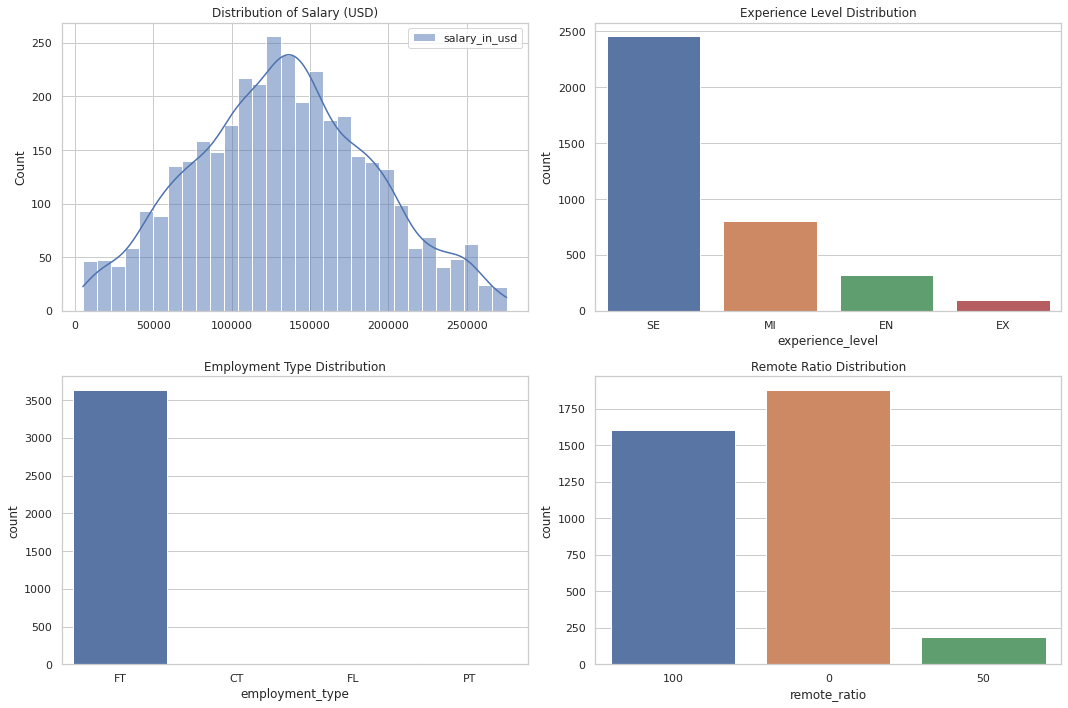

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Collecting data for plotting
salary_data = data_cleaned.select('salary_in_usd').toPandas()
experience_data = data_cleaned.select('experience_level').toPandas()
employment_type_data = data_cleaned.select('employment_type').toPandas()
remote_ratio_data = data_cleaned.select('remote_ratio').toPandas()

# Setting up the visualization environment
sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Salary distribution
sns.histplot(salary_data, bins=30, ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Distribution of Salary (USD)')

# Experience level distribution
sns.countplot(x='experience_level', data=experience_data, ax=axes[0, 1])
axes[0, 1].set_title('Experience Level Distribution')

# Employment type distribution
sns.countplot(x='employment_type', data=employment_type_data, ax=axes[1, 0])
axes[1, 0].set_title('Employment Type Distribution')

# Remote ratio distribution
sns.countplot(x='remote_ratio', data=remote_ratio_data, ax=axes[1, 1])
axes[1, 1].set_title('Remote Ratio Distribution')

plt.tight_layout()
plt.show()

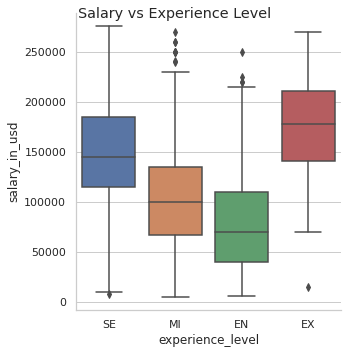

In [0]:
# Collecting data for plotting
salary_experience_data = data_cleaned.select('experience_level', 'salary_in_usd').toPandas()

# Plotting
salary_experience_plot = sns.catplot(x="experience_level", y="salary_in_usd", kind="box", data=salary_experience_data)
salary_experience_plot.fig.suptitle('Salary vs Experience Level')

plt.show()

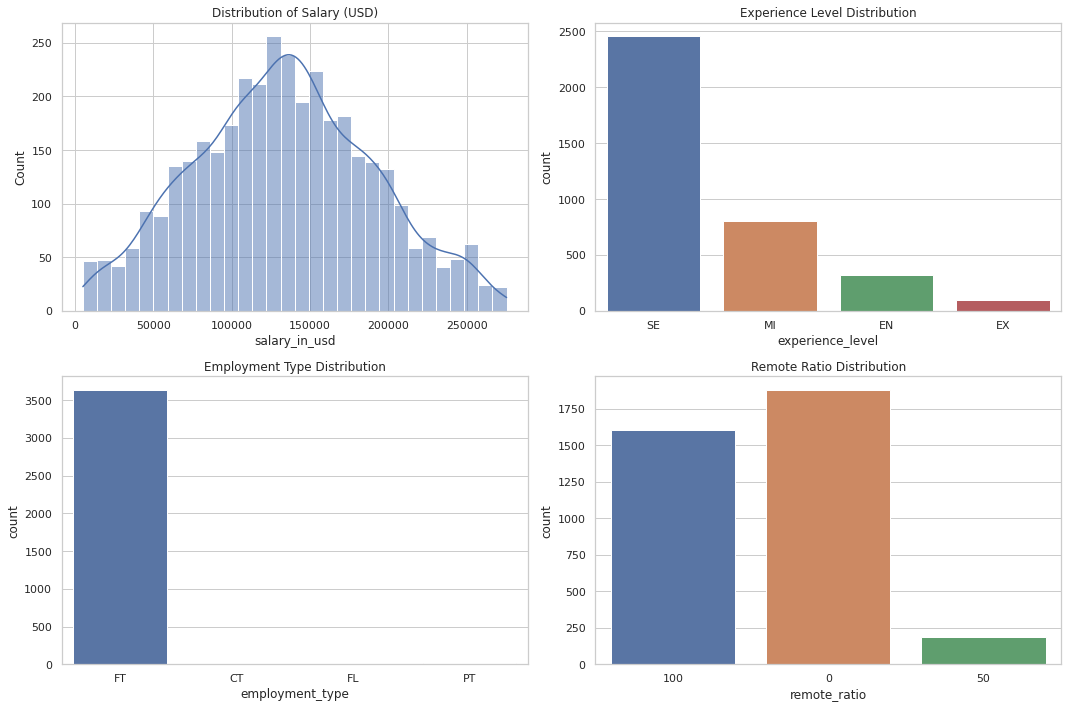

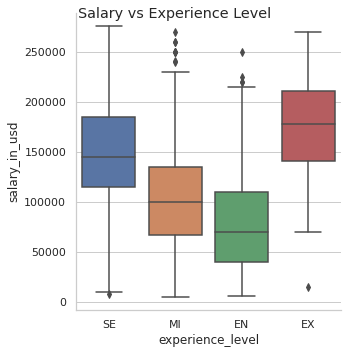

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Setting up the visualization environment
sns.set(style="whitegrid")

# Collecting necessary data from Spark to Pandas DataFrame for visualization
# Note: Be cautious with large datasets, as this can consume a lot of memory
data_pd = data_cleaned.select('salary_in_usd', 'experience_level', 'employment_type', 'remote_ratio').toPandas()

# Visualizing distributions
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Salary distribution
sns.histplot(data_pd['salary_in_usd'], bins=30, ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Distribution of Salary (USD)')

# Experience level distribution
sns.countplot(x='experience_level', data=data_pd, ax=axes[0, 1])
axes[0, 1].set_title('Experience Level Distribution')

# Employment type distribution
sns.countplot(x='employment_type', data=data_pd, ax=axes[1, 0])
axes[1, 0].set_title('Employment Type Distribution')

# Remote ratio distribution
sns.countplot(x='remote_ratio', data=data_pd, ax=axes[1, 1])
axes[1, 1].set_title('Remote Ratio Distribution')

plt.tight_layout()
plt.show()

# Scatter plot of Salary vs Experience Level
salary_experience_plot = sns.catplot(x="experience_level", y="salary_in_usd", kind="box", data=data_pd)
salary_experience_plot.fig.suptitle('Salary vs Experience Level')

plt.show()


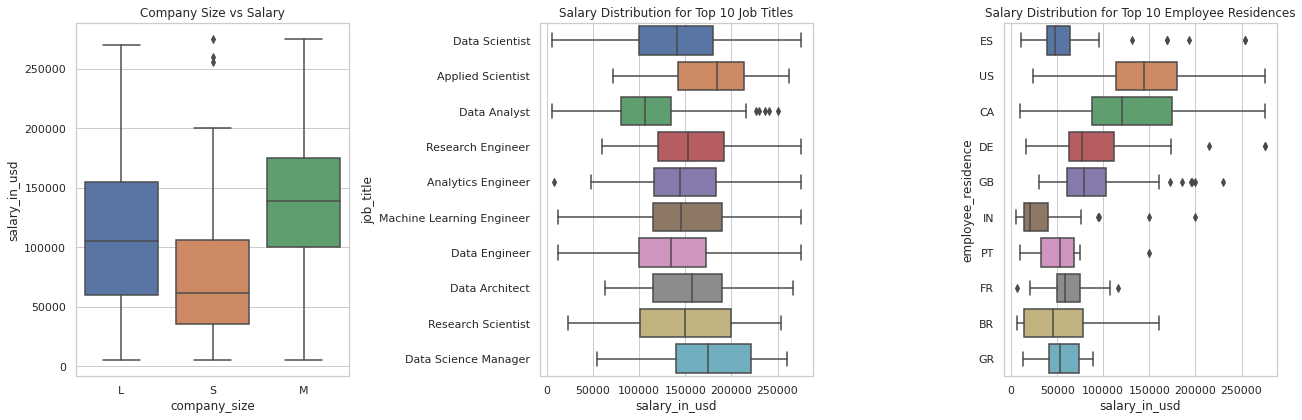

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming `data_cleaned` is your Spark DataFrame

# 1. Company Size vs Salary
company_size_salary = data_cleaned.select('company_size', 'salary_in_usd').toPandas()

# 2. Job Title vs Salary (Top 10 Job Titles by Frequency)
top_job_titles = data_cleaned.groupBy('job_title').count().orderBy('count', ascending=False).limit(10).toPandas()
top_job_titles_list = top_job_titles['job_title'].tolist()
filtered_data_job_title = data_cleaned.filter(data_cleaned['job_title'].isin(top_job_titles_list)).toPandas()

# 3. Employee Residence vs Salary (Top 10 Countries by Frequency)
top_residences = data_cleaned.groupBy('employee_residence').count().orderBy('count', ascending=False).limit(10).toPandas()
top_residences_list = top_residences['employee_residence'].tolist()
filtered_data_residence = data_cleaned.filter(data_cleaned['employee_residence'].isin(top_residences_list)).toPandas()

# Plotting
plt.figure(figsize=(18, 6))

# Company Size vs Salary
plt.subplot(1, 3, 1)
sns.boxplot(x='company_size', y='salary_in_usd', data=company_size_salary)
plt.title('Company Size vs Salary')

# Job Title vs Salary
plt.subplot(1, 3, 2)
sns.boxplot(x='salary_in_usd', y='job_title', data=filtered_data_job_title, orient='h')
plt.title('Salary Distribution for Top 10 Job Titles')

# Employee Residence vs Salary
plt.subplot(1, 3, 3)
sns.boxplot(x='salary_in_usd', y='employee_residence', data=filtered_data_residence, orient='h')
plt.title('Salary Distribution for Top 10 Employee Residences')

plt.tight_layout()
plt.show()

In [0]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline

# Encoding categorical variables
indexers = [StringIndexer(inputCol=column, outputCol=column+"_indexed").fit(data_cleaned) for column in categorical_columns]
pipeline = Pipeline(stages=indexers)
data_indexed = pipeline.fit(data_cleaned).transform(data_cleaned)

# Preparing the data for Random Forest
feature_columns = [column+"_indexed" for column in categorical_columns] + [col for col in data_indexed.columns if col not in categorical_columns + ['salary_in_usd']]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
output_data = assembler.transform(data_indexed)

# Separating the target variable and features
X = output_data.select("features")
y = output_data.select("salary_in_usd")

# Random Forest Regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="salary_in_usd", maxBins=1000)
rf_model = rf.fit(output_data)

# Getting feature importances (might need additional handling)
feature_importances = rf_model.featureImportances
